## Import libraries 

In [1]:
import pandas as pd
import nltk,re,string
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 
import warnings
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Read Data

In [2]:
data=pd.read_csv('./SMSCollection.csv',sep='\t',header=None,names=['label','text'])
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
print("Out of {} rows ,{} are spam and {} are ham".format(len(data),
                                                          len(data[data['label']=='spam']),
                                                          len(data[data['label']=='ham'])))

Out of 5572 rows ,747 are spam and 4825 are ham


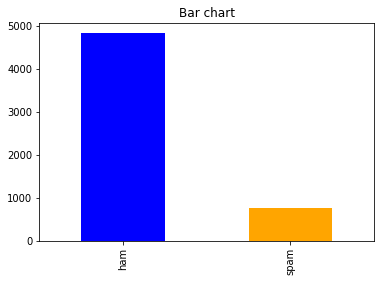

In [4]:
import matplotlib.pyplot as plt
count_Class=pd.value_counts(data["label"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

In [5]:
data['length'] = data['text'].apply(len)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C656D68>,
      dtype=object)

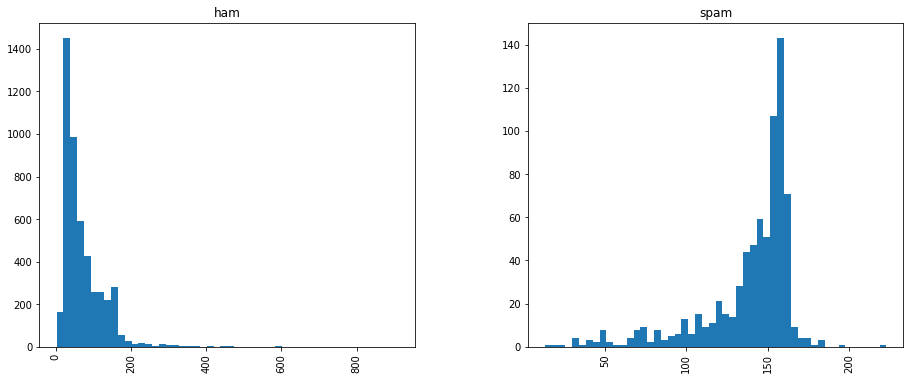

In [6]:
data.hist(column='length',by='label',bins=50, figsize=(15,6))

In [7]:
print("Number of null in label is {}".format(data['label'].isnull().sum()))
print("Number of null in text is {}".format(data['text'].isnull().sum()))

Number of null in label is 0
Number of null in text is 0


## Clean data

In [8]:
st=SnowballStemmer('english')
stopword=nltk.corpus.stopwords.words("english")
#function to perform basic cleaning tasks
def preprocess(text):
    text="".join([word.lower() for word in text if word not in string.punctuation])
    tokens=re.split('\W+',text)
    text=[st.stem(word) for word in tokens if word not in stopword]
    return text

## Feature Creation

In [9]:
#using tfidf for vectorizing data
tfidf=TfidfVectorizer(analyzer=preprocess)
x_tfidf=tfidf.fit_transform(data['text'])
#print(tfidf.get_feature_names())

In [10]:
#create features for a % of the text which is punctuation
def count_punct(text):
    count=sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100
data['text_len']=data['text'].apply(lambda x:len(x)-x.count(" "))
data['punct%']=data['text'].apply(lambda x:count_punct(x))
xfeatures=pd.concat([data['text_len'],data['punct%'],pd.DataFrame(x_tfidf.toarray())],axis=1)

## Model Creation

In [11]:
spam_filter = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer=preprocess)), 
    ('classifier', MultinomialNB(alpha=0.8))                    # hyperparamter setting
])

In [12]:
xtrain,xtest,ytrain,ytest=train_test_split(data['text'],(data['label']),test_size=0.2,random_state = 21)

In [13]:
spam_filter.fit(xtrain,ytrain)
ypred=spam_filter.predict((xtest))
accuracy_score(ytest,ypred)


0.9650224215246637

##  Metrics and  Visualization 

In [14]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       960
        spam       0.99      0.75      0.86       155

   micro avg       0.97      0.97      0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



In [120]:
def detect_spam(s):
    return spam_filter.predict([s])[0]
print(detect_spam(['Your email has received a prize money of Rs50000, contact 8974875785 to avail this offer']))
print(detect_spam(['Your cash-balance is currently 500 pounds - to maximize your cash-in now, send COLLECT to 83600.']))

ham
spam


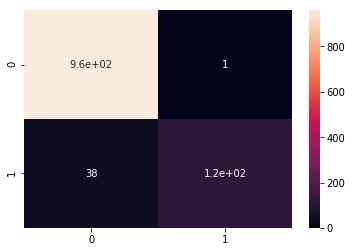

In [15]:
sns.heatmap(confusion_matrix(ytest,ypred),annot=True)